# Libraries

In [2]:
import os
import io
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from contextlib import redirect_stdout

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, Input
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import ParameterGrid

tf.get_logger().setLevel(logging.ERROR)

# Exploratory Data Analysis


Directory: test
	Subdir: 0 -> Number of files: 133
	Subdir: 1 -> Number of files: 275
	Subdir: 2 -> Number of files: 406
	Subdir: 3 -> Number of files: 1896
	Subdir: 4 -> Number of files: 39


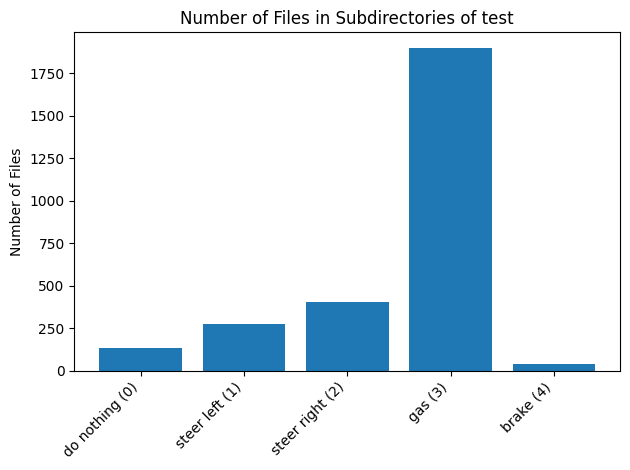




Directory: train
	Subdir: 0 -> Number of files: 1000
	Subdir: 1 -> Number of files: 1500
	Subdir: 2 -> Number of files: 1500
	Subdir: 3 -> Number of files: 2000
	Subdir: 4 -> Number of files: 369


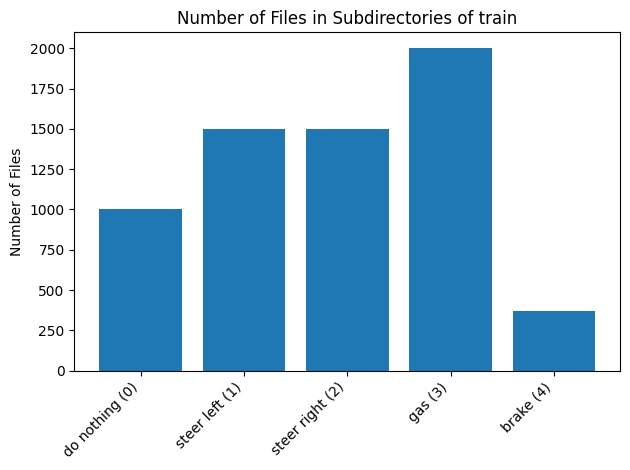

In [26]:
def plot_data_distr(source_folder):
    for dir in os.listdir(source_folder):
        if not dir.endswith('.zip'):
            print(f"\nDirectory: {dir}")
            subdir_names = []
            subdir_file_counts = []
            for subdir in os.listdir(os.path.join(source_folder, dir)):
                print(f"\tSubdir: {subdir} -> Number of files: {len(os.listdir(os.path.join(source_folder, dir, subdir)))}")
                label = f"{label_names.get(subdir, subdir)} ({subdir})"
                subdir_names.append(label)
                subdir_file_counts.append(len(os.listdir(os.path.join(source_folder, dir, subdir))))

            plt.figure()
            plt.bar(subdir_names, subdir_file_counts)
            plt.title(f'Number of Files in Subdirectories of {dir}')
            plt.ylabel('Number of Files')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            print("\n")

label_names = {
    '0': 'do nothing',
    '1': 'steer left',
    '2': 'steer right',
    '3': 'gas',
    '4': 'brake'
}

source_folder = 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data'
plot_data_distr(source_folder)

Exemplar images demonstrating clear classification


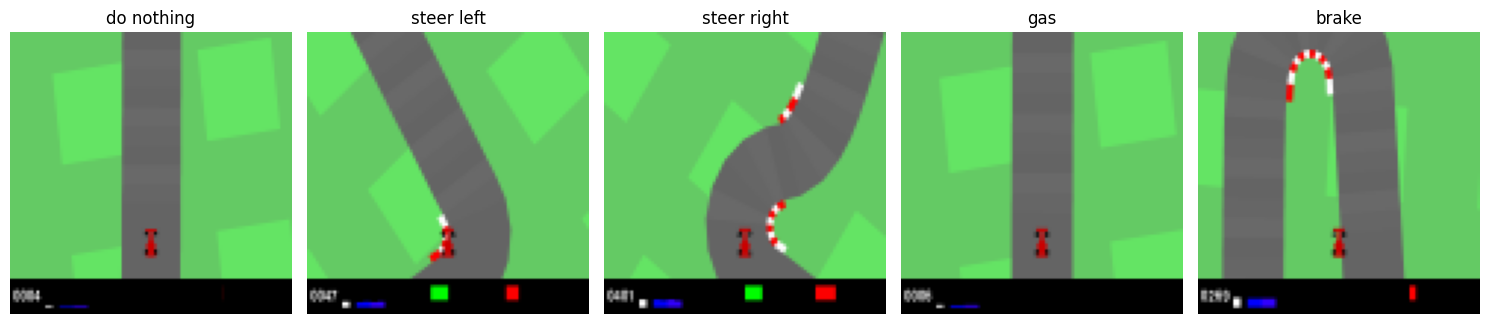


Images exhibiting potential noise or borderline classification characteristics


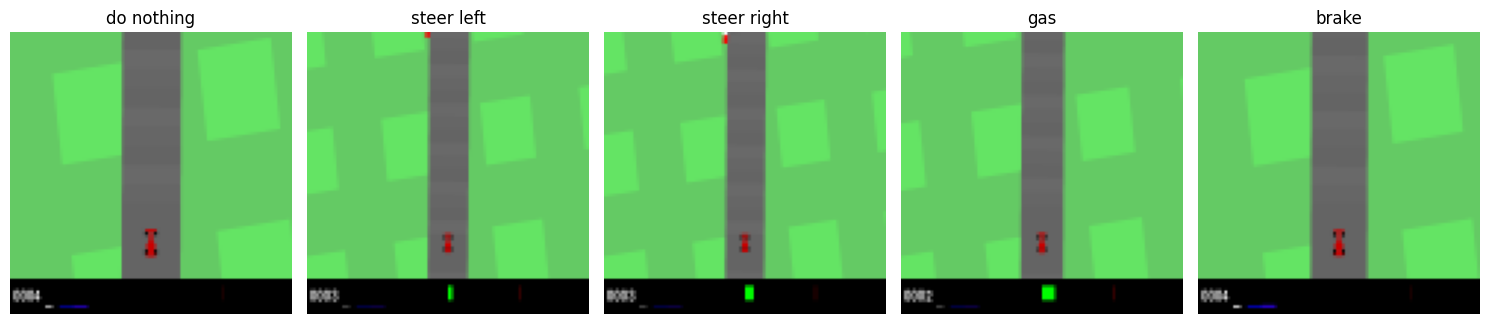

In [27]:
def plot_one_image_per_label(source_folder, label_names):
    fig, axs = plt.subplots(1, len(label_names), figsize=(15, 5))
    for label_id, label_name in label_names.items():
        image_found = False
        for dir in os.listdir(source_folder):
            if not dir.endswith('.zip'):  # Skip zip files
                label_path = os.path.join(source_folder, dir, label_id)
                if os.path.exists(label_path):  # Check if the label folder exists
                    for file in os.listdir(label_path):
                        image_path = os.path.join(label_path, file)
                        with Image.open(image_path) as img:
                            axs[int(label_id)].imshow(img)
                            axs[int(label_id)].axis('off')
                            axs[int(label_id)].set_title(label_name)
                            image_found = True
                            break
            if image_found:
                break
        if not image_found:  # Handle missing images for a label
            axs[int(label_id)].set_title(f"{label_name}\n(No Image)")
            axs[int(label_id)].axis('off')
    plt.tight_layout()
    plt.show()

def plot_chosen_images_per_label(label_names):
    image_paths = {
        '0': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\0\\0000.png',
        '1': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\1\\0009.png',
        '2': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\2\\0073.png',
        '3': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\3\\0021.png',
        '4': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\4\\0003.png'
    }
    fig, axs = plt.subplots(1, len(label_names), figsize=(15, 5))
    for i, (label_id, label_name) in enumerate(label_names.items()):
        if label_id in image_paths and os.path.exists(image_paths[label_id]):
            with Image.open(image_paths[label_id]) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
                axs[i].set_title(label_name)
        else:
            axs[i].set_title(f"{label_name}\n(No Image)")
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Exemplar images demonstrating clear classification")
plot_chosen_images_per_label(label_names)

print("\nImages exhibiting potential noise or borderline classification characteristics")
plot_one_image_per_label(source_folder, label_names)

# Data

## Data Preprocessing

In [5]:
def preprocess_image(image, label):  
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (96,96))
    return image, label

## Data Augmentation

In [6]:
def augment(image, label):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),  # Rotates images randomly 
        tf.keras.layers.RandomZoom(0.01),  # Zooms 
        tf.keras.layers.GaussianNoise(0.2)  # Random noise
    ])
    image = data_augmentation(image)
    image = tf.image.resize(image, (96,96)) 
    return image, label

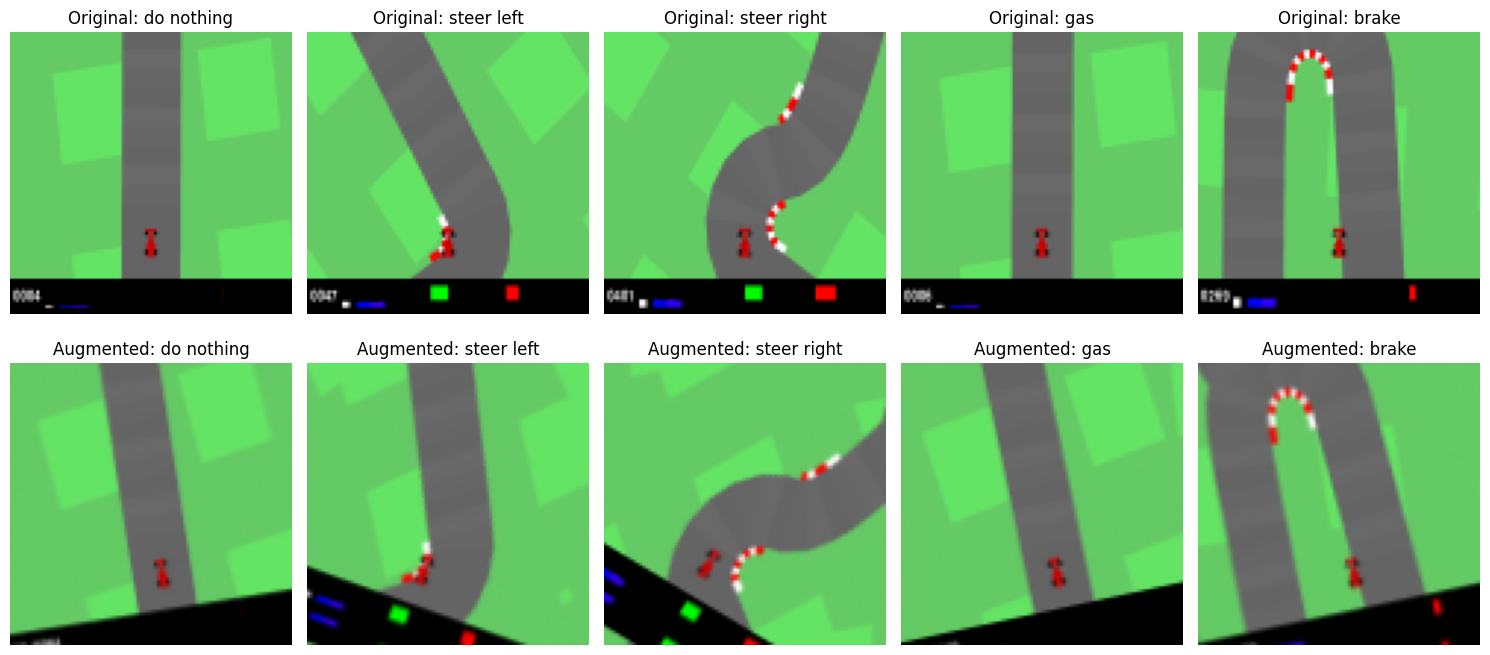

In [30]:
def apply_augmentation_and_plot(label_names):
    image_paths = {
        '0': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\0\\0000.png',
        '1': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\1\\0009.png',
        '2': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\2\\0073.png',
        '3': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\3\\0021.png',
        '4': 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test\\4\\0003.png'
    }

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),  # Rotates images randomly 
        tf.keras.layers.RandomZoom(0.01),  # Zooms 
        tf.keras.layers.GaussianNoise(0.2)  # Random noise
    ])

    fig, axs = plt.subplots(2, len(label_names), figsize=(15, 7))
    for i, (label_id, label_name) in enumerate(label_names.items()):
        if label_id in image_paths and os.path.exists(image_paths[label_id]):
            with Image.open(image_paths[label_id]) as img:
                img = img.resize((96, 96))  # Resize for consistency
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

            # Original image
            axs[0, i].imshow(img_array)
            axs[0, i].axis('off')
            axs[0, i].set_title(f"Original: {label_name}")
            # Augmented image
            augmented_img = data_augmentation(tf.expand_dims(img_array, axis=0))  
            axs[1, i].imshow(tf.squeeze(augmented_img)) 
            axs[1, i].axis('off')
            axs[1, i].set_title(f"Augmented: {label_name}")

    plt.tight_layout()
    plt.show()

apply_augmentation_and_plot(label_names)

# Metrics Computation and Performance Plot

In [4]:
def weighted_f1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true_classes = tf.argmax(y_true, axis=-1)
    
    y_pred_one_hot = tf.one_hot(y_pred_classes, depth=tf.shape(y_true)[-1])
    
    true_positives = tf.reduce_sum(y_true * y_pred_one_hot, axis=0)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred_one_hot, axis=0)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred_one_hot), axis=0)
    
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Handle NaN
    
    # Class Weights
    class_weights = tf.reduce_sum(y_true, axis=0)
    class_weights = class_weights / (tf.reduce_sum(class_weights) + tf.keras.backend.epsilon())
    
    weighted_f1_score = tf.reduce_sum(f1 * class_weights)
    return weighted_f1_score

def plot_confusion_matrix(cm, class_names):
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    display.plot( values_format='d')  
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_best_model(best_model, test_dataset):
    metrics_dict = {}
    y_true = []
    y_pred = []
    for x, y in test_dataset:
        y_true.extend(np.argmax(y.numpy(), axis=1))  # Convert one-hot encoded labels to class labels
        predictions = best_model.predict(x, verbose = 0)
        y_pred.extend(np.argmax(predictions, axis=1))  # Convert predicted probabilities to class labels
    
    metrics_dict['accuracy'] = accuracy_score(y_true, y_pred)
    class_names = [str(i) for i in range(5)]  # Class names from 0 to 4
    metrics_dict['classification_report'] = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    metrics_dict['confusion_matrix'] = confusion_matrix(y_true, y_pred)
  
    print(f"Test Accuracy: {metrics_dict['accuracy']:.5f}")
    print("\nClassification Report:\n")
    print(metrics_dict['classification_report'])
    print("\nConfusion Matrix:\n")
    plot_confusion_matrix(metrics_dict['confusion_matrix'], class_names)
    return metrics_dict

def plot_loss_evolution(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Bes Model Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def plot_weighetd_f1_evolution(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['weighted_f1'], label='Training weighted_f1')
    plt.plot(history.history['val_weighted_f1'], label='Validation weighted_f1')
    plt.title('Bes Model weighted_f1 Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('weighted_f1')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# First CNN

In [2]:
class CarActionClassifier_1:
    def __init__(self,
                 train_dir,
                 test_dir,
                 image_shape,
                 num_classes):

        self.train_dir = train_dir
        self.test_dir = test_dir
        self.image_shape = image_shape
        self.num_classes = num_classes

        # Datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def load_and_preprocess_dataset_1(self, batch_size, DataAugmentation):
        f = io.StringIO()
        with redirect_stdout(f):
            self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.train_dir,
                validation_split=0.2,
                seed=1944376,
                subset='training',
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical')

            self.val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.train_dir,
                validation_split=0.2,
                subset='validation',
                seed=1944376,
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical')

            self.test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.test_dir,
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical',
                shuffle=False )

        train_length_before = tf.data.experimental.cardinality(self.train_dataset).numpy()
        print("Length of train dataset BEFORE augmentation:", train_length_before)

        # Apply preprocessing to the TRAINING dataset
        self.train_dataset = self.train_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)
        self.val_dataset = self.val_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)
        self.test_dataset = self.test_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

        if DataAugmentation == True:
            augmented_dataset = self.train_dataset.map(augment).cache().prefetch(tf.data.AUTOTUNE) # Create augmented dataset
            self.train_dataset = self.train_dataset.concatenate(augmented_dataset) # Combine original and augmented datasets           
            # Merge and shuffle original and augmented dataset
            self.train_dataset = self.train_dataset.shuffle(buffer_size=len(self.train_dataset)) 
            train_length_after = tf.data.experimental.cardinality(self.train_dataset).numpy()
            print("Length of train dataset AFTER augmentation:", train_length_after)


    def create_cnn_model_1(self, num_units, stride, learning_rate):

        model = tf.keras.Sequential([Input(shape=self.image_shape)])

        model.add(layers.Conv2D(num_units, 3, strides=stride, padding='same', activation='relu'))
        model.add(layers.BatchNormalization()) 
        model.add(layers.AveragePooling2D((2, 2)))

        model.add(layers.Conv2D(num_units, 3, strides=stride, padding='same', activation='relu'))
        model.add(layers.BatchNormalization()) 
        model.add(layers.AveragePooling2D((2, 2)))

        model.add(layers.Conv2D(num_units, 3, strides=stride, padding='same', activation='relu'))
        model.add(layers.BatchNormalization()) 
        model.add(layers.AveragePooling2D((2, 2)))

        model.add(layers.Flatten())
        model.add(layers.Dense(num_units*2, activation='relu'))
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)        

        metrics = ['accuracy', weighted_f1]

        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=metrics)
        return model

    def train_and_evaluate_1(self, model, batch_size, epochs):

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[early_stopping])
        
        val_accuracy = max(history.history['val_accuracy'])
        val_weighted_f1 = max(history.history['val_weighted_f1'])
        
        val_metrics = {
            "val_accuracy": round(val_accuracy, 5),
            "val_weighted_f1": round(val_weighted_f1, 5),
            "train_val_history": history    }

        test_loss, test_accuracy, test_weighted_f1= model.evaluate(self.test_dataset, verbose=0)

        test_metrics = {
            "test_accuracy": round(test_accuracy, 5),
            "test_weighted_f1": round(test_weighted_f1, 5),
            "test_loss": test_loss  }

        return val_metrics, test_metrics

    def grid_search_1(self, param_grid, DataAugmentation):
        best_params = None
        best_val_f1 = 0
        best_results = ()
        best_model = None

        total_combinations = len(list(ParameterGrid(param_grid)))

        for index, params in enumerate(ParameterGrid(param_grid), 1):
            print(f"Testing configuration {index}/{total_combinations}: {params}")

            self.load_and_preprocess_dataset_1(batch_size=params['batch_size'], DataAugmentation=DataAugmentation)
            model = self.create_cnn_model_1(
                num_units=params['num_units'],
                stride=params['stride'],
                learning_rate=params['learning_rate']
                )

            val_metrics, test_metrics = self.train_and_evaluate_1(
                model, batch_size=params['batch_size'], epochs=params['epochs'])

            if val_metrics["val_weighted_f1"] > best_val_f1:
                best_val_f1 = val_metrics["val_weighted_f1"]
                best_params = params
                best_results = (val_metrics, test_metrics)
                best_model = model 

            print(f"MAX Validation F1-weighted: {val_metrics['val_weighted_f1']}\n")

        return best_params, best_results, best_model

## Without Data Augmentation

In [35]:
param_grid = {
    'num_units': [20, 30], 
    'stride': [1, 2],
    'learning_rate': [0.0001, 0.00001],
    'batch_size': [32, 64], 
    'epochs': [40]
}

train_dir ='C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\train'
test_dir = 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test'
    
image_shape = (96, 96, 3)
num_classes = 5
DataAugmentation = False
classifier_1_NO_DA = CarActionClassifier_1(train_dir, test_dir, image_shape, num_classes)
best_params_1_NO_DA, best_results_1_NO_DA, best_model_1_NO_DA = classifier_1_NO_DA.grid_search_1(param_grid, DataAugmentation)

best_model_1_NO_DA.save_weights("BM_weights_CNN_1_NO_DA.weights.h5")
best_model_1_NO_DA.save("BM_weights_CNN_1_NO_DA.h5")       

Testing configuration 1/16: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.0001, 'num_units': 20, 'stride': 1}
Length of train dataset BEFORE augmentation: 160
Epoch 1/40
160/160 [==============================] - 34s 206ms/step - loss: 1.2582 - accuracy: 0.5306 - weighted_f1: 0.4746 - val_loss: 1.5856 - val_accuracy: 0.2302 - val_weighted_f1: 0.0935
Epoch 2/40
160/160 [==============================] - 29s 184ms/step - loss: 1.0917 - accuracy: 0.5928 - weighted_f1: 0.5558 - val_loss: 1.6344 - val_accuracy: 0.3158 - val_weighted_f1: 0.2322
Epoch 3/40
160/160 [==============================] - 30s 187ms/step - loss: 1.0300 - accuracy: 0.6158 - weighted_f1: 0.5851 - val_loss: 1.3409 - val_accuracy: 0.4470 - val_weighted_f1: 0.3866
Epoch 4/40
160/160 [==============================] - 30s 187ms/step - loss: 0.9856 - accuracy: 0.6346 - weighted_f1: 0.6076 - val_loss: 1.0463 - val_accuracy: 0.6214 - val_weighted_f1: 0.6020
Epoch 5/40
160/160 [==============================] - 29s 183ms

In [36]:
print(f"Best Configuration:\t{best_params_1_NO_DA}")       
print(f"Best Validation f1:\t{best_results_1_NO_DA[0]['val_weighted_f1']:.5f}")
print(f"Best Test  Results:\t{best_results_1_NO_DA[1]}")
print(f"Best Testing f1: {best_results_1_NO_DA[1]['test_weighted_f1']:.5f}")

Best Configuration:	{'batch_size': 64, 'epochs': 40, 'learning_rate': 0.0001, 'num_units': 20, 'stride': 1}
Best Validation f1:	0.65951
Best Test  Results:	{'test_accuracy': 0.63441, 'test_weighted_f1': 0.74776, 'test_loss': 1.031291127204895}
Best Testing f1: 0.74776


Test Accuracy: 0.63441

Classification Report:

              precision    recall  f1-score   support

           0       0.25      0.49      0.33       133
           1       0.35      0.55      0.43       275
           2       0.51      0.65      0.58       406
           3       0.86      0.66      0.75      1896
           4       0.06      0.13      0.08        39

    accuracy                           0.63      2749
   macro avg       0.41      0.50      0.43      2749
weighted avg       0.72      0.63      0.66      2749


Confusion Matrix:



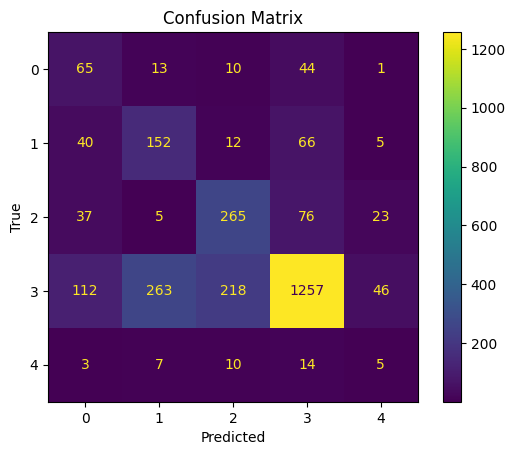

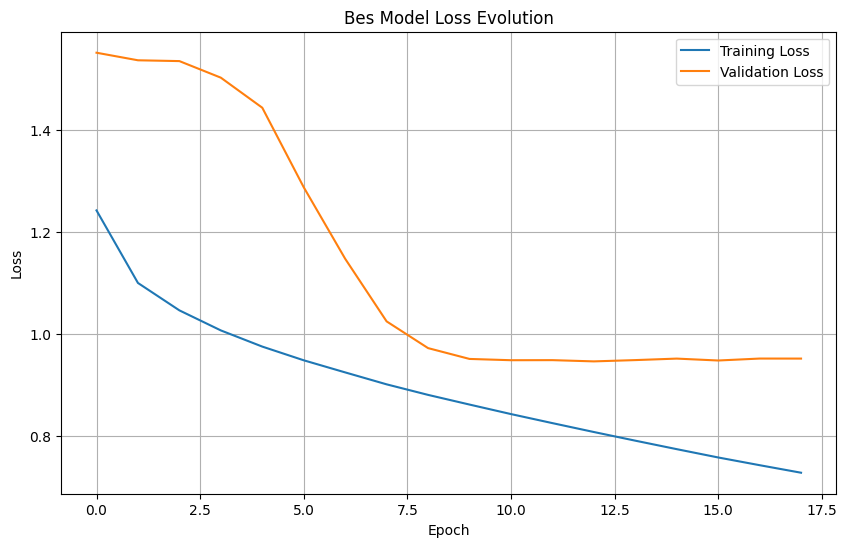

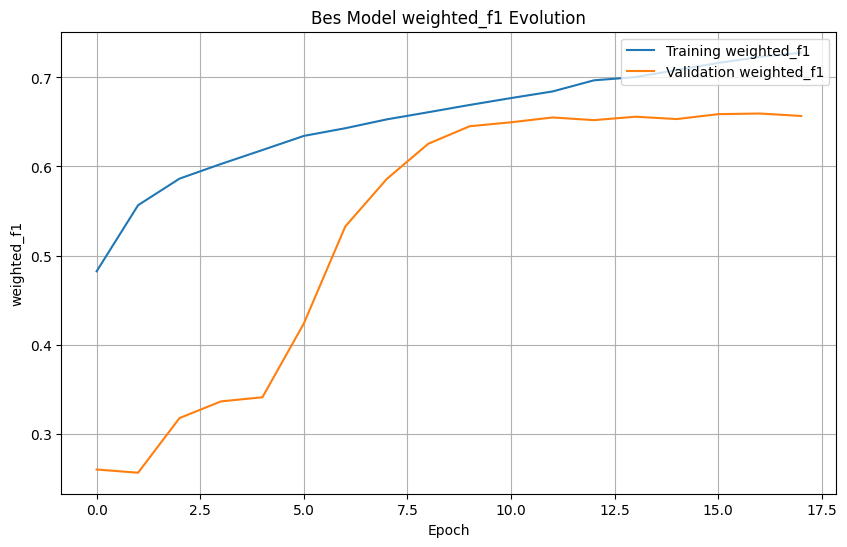

In [37]:
metrics = evaluate_best_model(best_model_1_NO_DA, classifier_1_NO_DA.test_dataset)
BM_TV_hist = best_results_1_NO_DA[0]['train_val_history'] #best model train val loss
plot_loss_evolution(BM_TV_hist)
plot_weighetd_f1_evolution(BM_TV_hist)

## With Data Augmentation

In [38]:
param_grid = {
    'num_units': [20, 30], 
    'stride': [1, 2],
    'learning_rate': [0.0001, 0.00001],
    'batch_size': [32, 64], 
    'epochs': [40]
}

train_dir ='C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\train'
test_dir = 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test'
    
image_shape = (96, 96, 3)
num_classes = 5
DataAugmentation = True
classifier_1_DA = CarActionClassifier_1(train_dir, test_dir, image_shape, num_classes)
best_params_1_DA, best_results_1_DA, best_model_1_DA = classifier_1_DA.grid_search_1(param_grid, DataAugmentation)

best_model_1_DA.save_weights("BM_weights_CNN_1_DA.weights.h5")
best_model_1_DA.save("BM_weights_CNN_1_DA.h5")       

Testing configuration 1/16: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.0001, 'num_units': 20, 'stride': 1}
Length of train dataset BEFORE augmentation: 160
Length of train dataset AFTER augmentation: 320
Epoch 1/40
320/320 [==============================] - 69s 201ms/step - loss: 1.2134 - accuracy: 0.5402 - weighted_f1: 0.5034 - val_loss: 1.5445 - val_accuracy: 0.2388 - val_weighted_f1: 0.1843
Epoch 2/40
320/320 [==============================] - 62s 194ms/step - loss: 1.1068 - accuracy: 0.5866 - weighted_f1: 0.5539 - val_loss: 1.0606 - val_accuracy: 0.6206 - val_weighted_f1: 0.5920
Epoch 3/40
320/320 [==============================] - 64s 199ms/step - loss: 1.0598 - accuracy: 0.6055 - weighted_f1: 0.5759 - val_loss: 1.0026 - val_accuracy: 0.6269 - val_weighted_f1: 0.5968
Epoch 4/40
320/320 [==============================] - 64s 200ms/step - loss: 1.0224 - accuracy: 0.6188 - weighted_f1: 0.5926 - val_loss: 0.9874 - val_accuracy: 0.6544 - val_weighted_f1: 0.6344
Epoch 5/40
320/

In [39]:
print(f"Best Configuration:\t{best_params_1_DA}")       
print(f"Best Validation f1:\t{best_results_1_DA[0]['val_weighted_f1']:.5f}")
print(f"Best Test  Results:\t{best_results_1_DA[1]}")
print(f"Best Testing f1: {best_results_1_DA[1]['test_weighted_f1']:.5f}")

Best Configuration:	{'batch_size': 64, 'epochs': 40, 'learning_rate': 0.0001, 'num_units': 30, 'stride': 1}
Best Validation f1:	0.67215
Best Test  Results:	{'test_accuracy': 0.48381, 'test_weighted_f1': 0.61476, 'test_loss': 1.3568295240402222}
Best Testing f1: 0.61476


Test Accuracy: 0.48381

Classification Report:

              precision    recall  f1-score   support

           0       0.18      0.49      0.26       133
           1       0.30      0.67      0.41       275
           2       0.45      0.70      0.55       406
           3       0.89      0.42      0.57      1896
           4       0.03      0.18      0.05        39

    accuracy                           0.48      2749
   macro avg       0.37      0.49      0.37      2749
weighted avg       0.72      0.48      0.53      2749


Confusion Matrix:



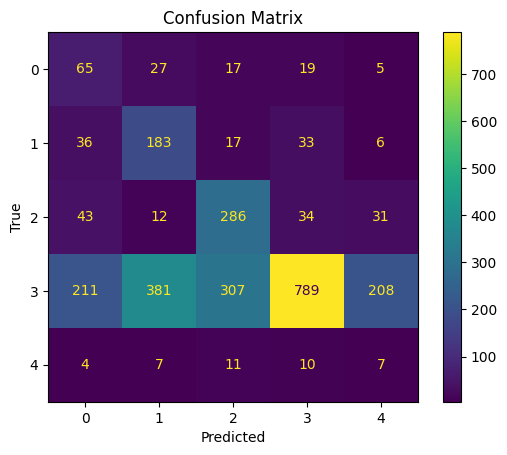

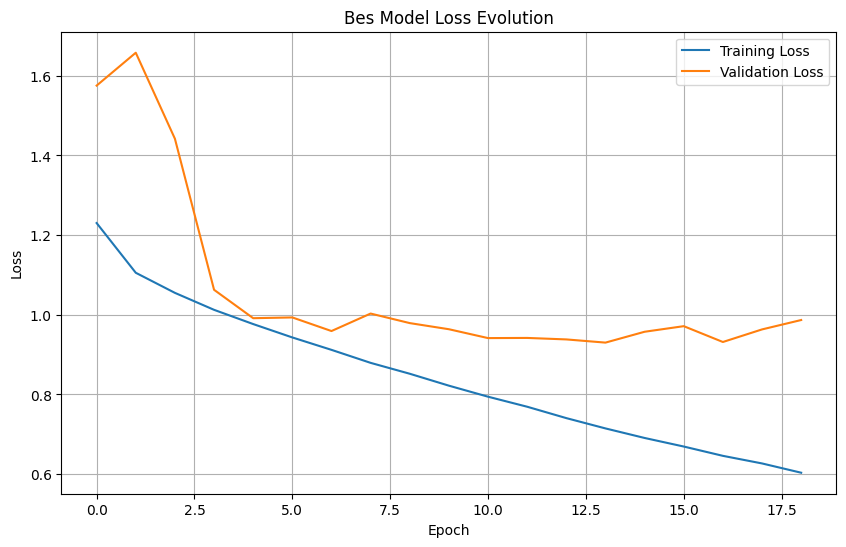

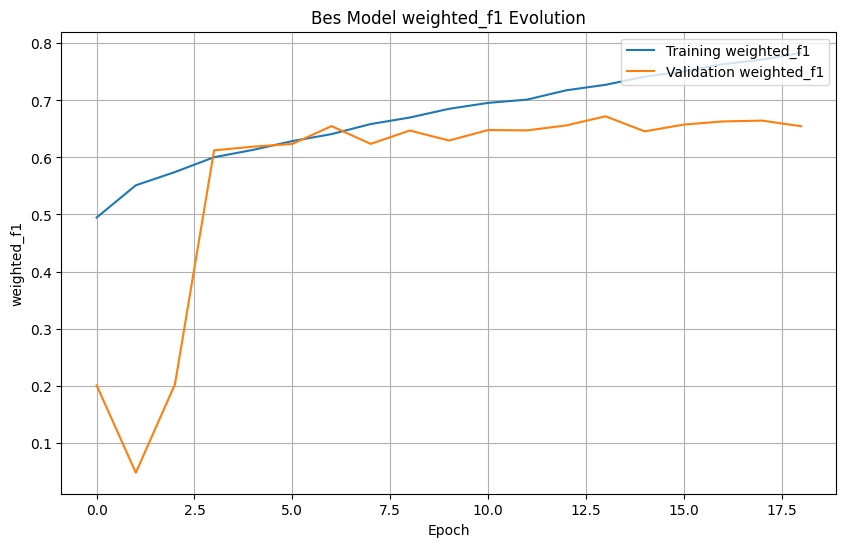

In [40]:
metrics = evaluate_best_model(best_model_1_DA, classifier_1_DA.test_dataset)
BM_TV_hist = best_results_1_DA[0]['train_val_history'] #best model train val loss
plot_loss_evolution(BM_TV_hist)
plot_weighetd_f1_evolution(BM_TV_hist)

# Second CNN

In [42]:
class CarActionClassifier_2:
    def __init__(self,
                 train_dir,
                 test_dir,
                 image_shape,
                 num_classes):

        self.train_dir = train_dir
        self.test_dir = test_dir
        self.image_shape = image_shape
        self.num_classes = num_classes

        # Datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def load_and_preprocess_dataset_2(self, batch_size, DataAugmentation):
 
        f = io.StringIO() #avoid printing the output of the function
        with redirect_stdout(f):
            self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.train_dir,
                validation_split=0.2,
                seed=1944376,
                subset='training',
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical')

            self.val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.train_dir,
                validation_split=0.2,
                subset='validation',
                seed=1944376,
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical')

            self.test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                self.test_dir,
                image_size=self.image_shape[:2],
                batch_size=batch_size,
                label_mode='categorical',
                shuffle=False )

        train_length_before = tf.data.experimental.cardinality(self.train_dataset).numpy()
        print("Length of train dataset BEFORE augmentation:", train_length_before)

        # Apply preprocessing to the TRAINING dataset
        self.train_dataset = self.train_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)
        self.val_dataset = self.val_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)
        self.test_dataset = self.test_dataset.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

        if DataAugmentation == True:
            augmented_dataset = self.train_dataset.map(augment).cache().prefetch(tf.data.AUTOTUNE) # Create augmented dataset
            self.train_dataset = self.train_dataset.concatenate(augmented_dataset) # Combine original and augmented datasets           
            # Merge and shuffle original and augmented dataset
            self.train_dataset = self.train_dataset.shuffle(buffer_size=len(self.train_dataset)) # Shuffle the combined dataset
            train_length_after = tf.data.experimental.cardinality(self.train_dataset).numpy()
            print("Length of train dataset AFTER augmentation:", train_length_after)


    def create_cnn_model_2(self, num_layers, num_units, kernel_size, learning_rate, num_cel_dense, drop_out_val, num_dense):
        model = tf.keras.Sequential([Input(shape=self.image_shape)])

        for i in range(num_layers):
            model.add(layers.Conv2D(num_units, kernel_size, strides=2, padding='same', activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
            num_units = num_units * 2 #make it incremental

        model.add(layers.GlobalAveragePooling2D())
        
        for j in range(num_dense):
            model.add(layers.Dense(num_cel_dense, activation='relu'))
            model.add(layers.Dropout(drop_out_val))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                
        metrics = ['accuracy', weighted_f1]
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=metrics)
        return model

    def train_and_evaluate_2(self, model, batch_size, epochs):

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[early_stopping])
        
        val_accuracy = max(history.history['val_accuracy'])
        val_weighted_f1 = max(history.history['val_weighted_f1'])
        
        val_metrics = {
            "val_accuracy": round(val_accuracy, 5),
            "val_weighted_f1": round(val_weighted_f1, 5),
            "train_val_history": history}

        test_loss, test_accuracy, test_weighted_f1= model.evaluate(self.test_dataset, verbose=0)

        test_metrics = {
            "test_accuracy": round(test_accuracy, 5),
            "test_weighted_f1": round(test_weighted_f1, 5)
        }

        return val_metrics, test_metrics

    def grid_search_2(self, param_grid, DataAugmentation):
        
        best_params = None
        best_val_f1 = 0
        best_results = ()
        best_model = None

        total_combinations = len(list(ParameterGrid(param_grid)))

        for index, params in enumerate(ParameterGrid(param_grid), 1):
            print(f"Testing configuration {index}/{total_combinations}: {params}")

            self.load_and_preprocess_dataset_2(batch_size=params['batch_size'], DataAugmentation=DataAugmentation)
            
            model = self.create_cnn_model_2(
                num_layers=params['num_layers'],
                num_units=params['num_units'],
                kernel_size=params['kernel_size'],
                learning_rate=params['learning_rate'],
                num_cel_dense=params['num_cel_dense'],
                drop_out_val = params['drop_out_val'],
                num_dense = params['num_dense']
                  )
                
            val_metrics, test_metrics = self.train_and_evaluate_2(
                    model, batch_size=params['batch_size'], epochs=params['epochs'])

            if val_metrics["val_weighted_f1"] > best_val_f1:
                best_val_f1 = val_metrics["val_weighted_f1"]
                best_params = params
                best_results = (val_metrics, test_metrics)
                best_model = model 

            print(f"MAX Validation F1-weighted: {val_metrics['val_weighted_f1']}\n")
        
        return best_params, best_results, best_model

## Without Data Augmentation

In [10]:
param_grid = {
    'num_layers': [3], #conv layer (NOT DENSE)
    'num_units': [64], #starting num of filters in conv layer, then double
    'kernel_size': [5, 7],
    'learning_rate': [0.0001],
    'batch_size': [32],
    'epochs': [40],
    'num_cel_dense' : [32, 64],
    'drop_out_val' : [0.25, 0.5],
    'num_dense' : [1, 2]
}

train_dir ='C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\train'
test_dir = 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test'
    
image_shape = (96, 96, 3)
num_classes = 5
DataAugmentation = False
classifier_2_NO_DA = CarActionClassifier_2(train_dir, test_dir, image_shape, num_classes)
best_params_2_NO_DA, best_results_2_NO_DA, best_model_2_NO_DA = classifier_2_NO_DA.grid_search_2(param_grid, DataAugmentation)

best_model_1_NO_DA.save_weights("BM_weights_CNN_2_NO_DA.weights.h5")
best_model_1_NO_DA.save("BM_weights_CNN_2_NO_DA.h5") 

Testing configuration 1/16: {'batch_size': 32, 'drop_out_val': 0.25, 'epochs': 40, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_cel_dense': 32, 'num_dense': 1, 'num_layers': 3, 'num_units': 64}
Length of train dataset BEFORE augmentation: 160
Epoch 1/40
160/160 [==============================] - 19s 113ms/step - loss: 1.4254 - accuracy: 0.3985 - weighted_f1: 0.3438 - val_loss: 1.2637 - val_accuracy: 0.5389 - val_weighted_f1: 0.4755
Epoch 2/40
160/160 [==============================] - 23s 141ms/step - loss: 1.2501 - accuracy: 0.5359 - weighted_f1: 0.4864 - val_loss: 1.1512 - val_accuracy: 0.5994 - val_weighted_f1: 0.5495
Epoch 3/40
160/160 [==============================] - 20s 124ms/step - loss: 1.2096 - accuracy: 0.5630 - weighted_f1: 0.5162 - val_loss: 1.1329 - val_accuracy: 0.6080 - val_weighted_f1: 0.5733
Epoch 4/40
160/160 [==============================] - 23s 146ms/step - loss: 1.1774 - accuracy: 0.5716 - weighted_f1: 0.5326 - val_loss: 1.1201 - val_accuracy: 0.6143 - val_we

In [9]:
print(f"Best Configuration:\t{best_params_2_NO_DA}")       
print(f"Best Validation f1:\t{best_results_2_NO_DA[0]['val_weighted_f1']:.5f}")
print(f"Best Test  Results:\t{best_results_2_NO_DA[1]}")
print(f"Best Testing f1: {best_results_2_NO_DA[1]['test_weighted_f1']:.5f}")

Best Configuration:	{'batch_size': 32, 'drop_out_val': 0.5, 'epochs': 40, 'kernel_size': 7, 'learning_rate': 0.0001, 'num_cel_dense': 32, 'num_dense': 1, 'num_layers': 3, 'num_units': 64}
Best Validation f1:	0.67692
Best Test  Results:	{'test_accuracy': 0.60858, 'test_weighted_f1': 0.70163}
Best Testing f1:	0.70163


Test Accuracy: 0.60858

Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.53      0.31       133
           1       0.35      0.61      0.44       275
           2       0.47      0.69      0.56       406
           3       0.88      0.61      0.72      1896
           4       0.09      0.08      0.08        39

    accuracy                           0.61      2749
   macro avg       0.40      0.50      0.42      2749
weighted avg       0.72      0.61      0.64      2749


Confusion Matrix:



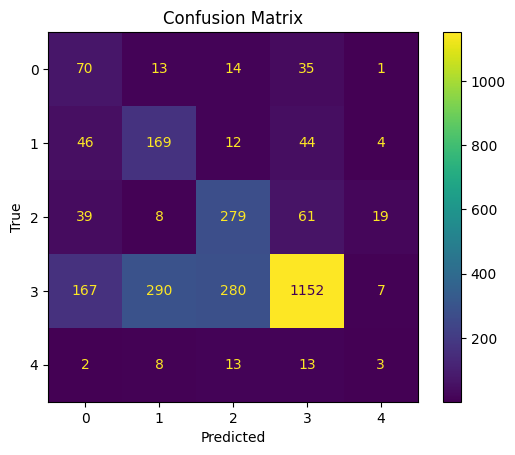

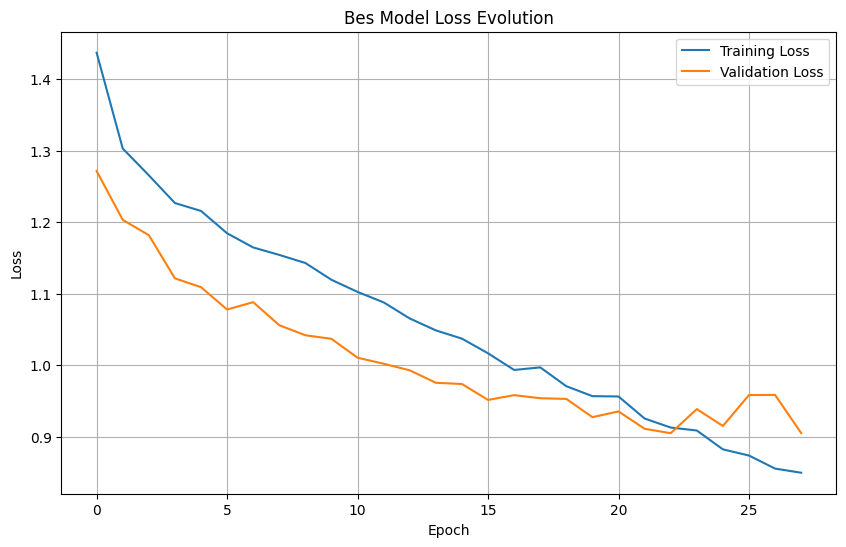

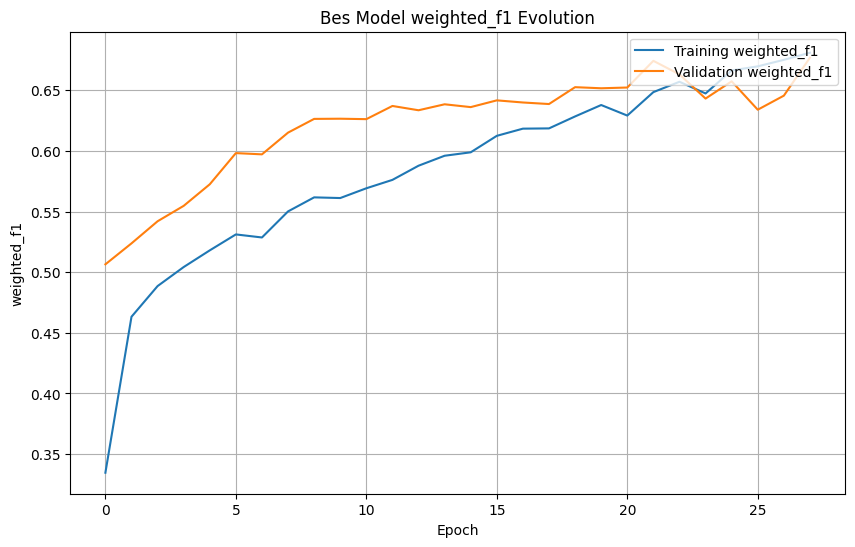

In [17]:
metrics = evaluate_best_model(best_model_2_NO_DA, classifier_2_NO_DA.test_dataset)
BM_TV_hist = best_results_2_NO_DA[0]['train_val_history'] #best model train val loss
plot_loss_evolution(BM_TV_hist)
plot_weighetd_f1_evolution(BM_TV_hist)

## With Data Augmentation

In [43]:

param_grid = {
    'num_layers': [3], #conv layer (NOT DENSE)
    'num_units': [64], #starting num of filters in conv layer, then double
    'kernel_size': [5, 7],
    'learning_rate': [0.0001],
    'batch_size': [32],
    'epochs': [40],
    'num_cel_dense' : [32, 64],
    'drop_out_val' : [0.25, 0.5],
    'num_dense' : [1, 2]
}

train_dir ='C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\train'
test_dir = 'C:\\Users\\giuse\\OneDrive - uniroma1.it\\Desktop\\magistrale\\1_1\\machine learning\\Second Homework\\data\\test'
    
image_shape = (96, 96, 3)
num_classes = 5
DataAugmentation = True
classifier_2_DA = CarActionClassifier_2(train_dir, test_dir, image_shape, num_classes)
best_params_2_DA, best_results_2_DA, best_model_2_DA = classifier_2_DA.grid_search_2(param_grid, DataAugmentation)

best_model_2_DA.save_weights("BM_weights_CNN_2_DA.weights.h5")
best_model_2_DA.save("BM_weights_CNN_2_DA.h5") 

Testing configuration 1/16: {'batch_size': 32, 'drop_out_val': 0.25, 'epochs': 40, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_cel_dense': 32, 'num_dense': 1, 'num_layers': 3, 'num_units': 64}
Length of train dataset BEFORE augmentation: 160
Length of train dataset AFTER augmentation: 320
Epoch 1/40
320/320 [==============================] - 68s 198ms/step - loss: 1.3506 - accuracy: 0.4641 - weighted_f1: 0.4087 - val_loss: 1.1710 - val_accuracy: 0.5687 - val_weighted_f1: 0.5048
Epoch 2/40
320/320 [==============================] - 72s 226ms/step - loss: 1.2362 - accuracy: 0.5383 - weighted_f1: 0.4870 - val_loss: 1.1182 - val_accuracy: 0.6033 - val_weighted_f1: 0.5536
Epoch 3/40
320/320 [==============================] - 68s 212ms/step - loss: 1.1996 - accuracy: 0.5519 - weighted_f1: 0.5065 - val_loss: 1.0816 - val_accuracy: 0.6033 - val_weighted_f1: 0.5545
Epoch 4/40
320/320 [==============================] - 67s 210ms/step - loss: 1.1654 - accuracy: 0.5725 - weighted_f1: 0.5314 - 

In [44]:
print(f"Best Configuration:\t{best_params_2_DA}")       
print(f"Best Validation f1:\t{best_results_2_DA[0]['val_weighted_f1']:.5f}")
print(f"Best Test  Results:\t{best_results_2_DA[1]}")
print(f"Best Testing f1: {best_results_2_DA[1]['test_weighted_f1']:.5f}")

Best Configuration:	{'batch_size': 32, 'drop_out_val': 0.25, 'epochs': 40, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_cel_dense': 64, 'num_dense': 2, 'num_layers': 3, 'num_units': 64}
Best Validation f1:	0.69176
Best Test  Results:	{'test_accuracy': 0.53692, 'test_weighted_f1': 0.64645}
Best Testing f1: 0.64645


Test Accuracy: 0.53692

Classification Report:

              precision    recall  f1-score   support

           0       0.16      0.54      0.25       133
           1       0.32      0.61      0.42       275
           2       0.47      0.69      0.56       406
           3       0.88      0.50      0.64      1896
           4       0.08      0.21      0.11        39

    accuracy                           0.54      2749
   macro avg       0.38      0.51      0.40      2749
weighted avg       0.72      0.54      0.58      2749


Confusion Matrix:



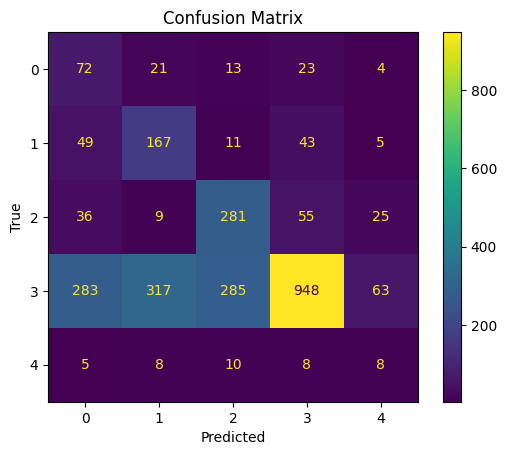

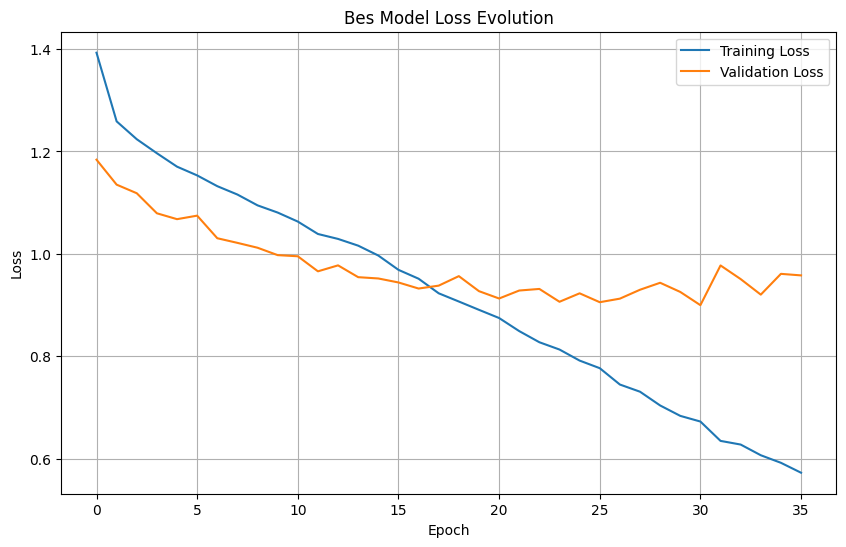

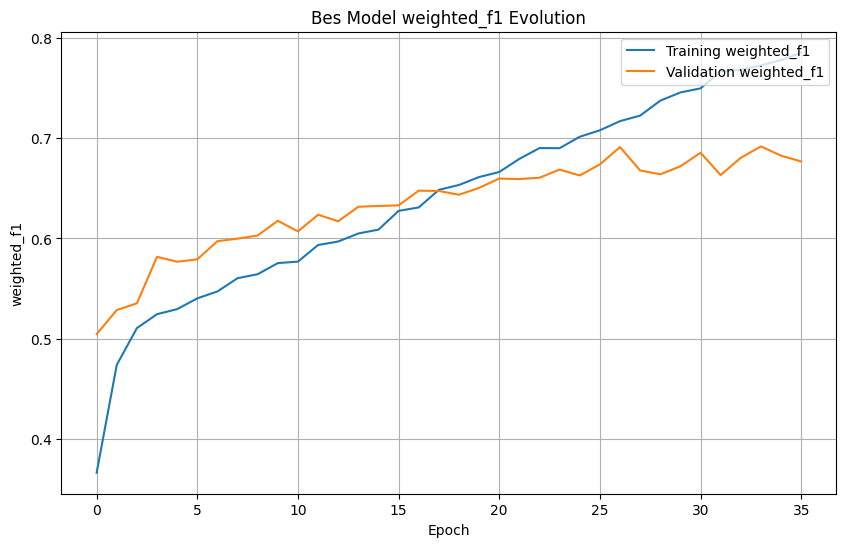

In [45]:
metrics = evaluate_best_model(best_model_2_DA, classifier_2_DA.test_dataset)
BM_TV_hist = best_results_2_DA[0]['train_val_history'] #best model train val loss
plot_loss_evolution(BM_TV_hist)
plot_weighetd_f1_evolution(BM_TV_hist)